<a href="https://colab.research.google.com/github/koad7/uol_final/blob/main/FINAL_UOL_BASELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q  transformers
!pip install -q nltk node2vec
!pip install -q haversine
!pip  install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [1]:
from pathlib import Path
from google.colab import drive
import os
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import requests
import pickle
import copy
import numpy as np
import gc

In [3]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/')
FINAL_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/final_work')
WORKDIR_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/')

In [3]:
what = 'read'
if what == 'read':
  train_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/train_10_15.parquet')
  test_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/test_10_15.parquet')
  val_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/val_10_15.parquet')

  train_20_25 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/train_20_25.parquet')
  test_20_25 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/test_20_25.parquet')
  val_20_25 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/val_20_25.parquet')


# DATA STAT

In [63]:
train_10_15_df = train_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:70]
val_10_15_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:15]
test_10_15_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:15]


train_20_25_df = train_20_25[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]
val_20_25_df = val_20_25[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]
test_20_25_df = val_20_25[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]

###### 10_15 samples per country

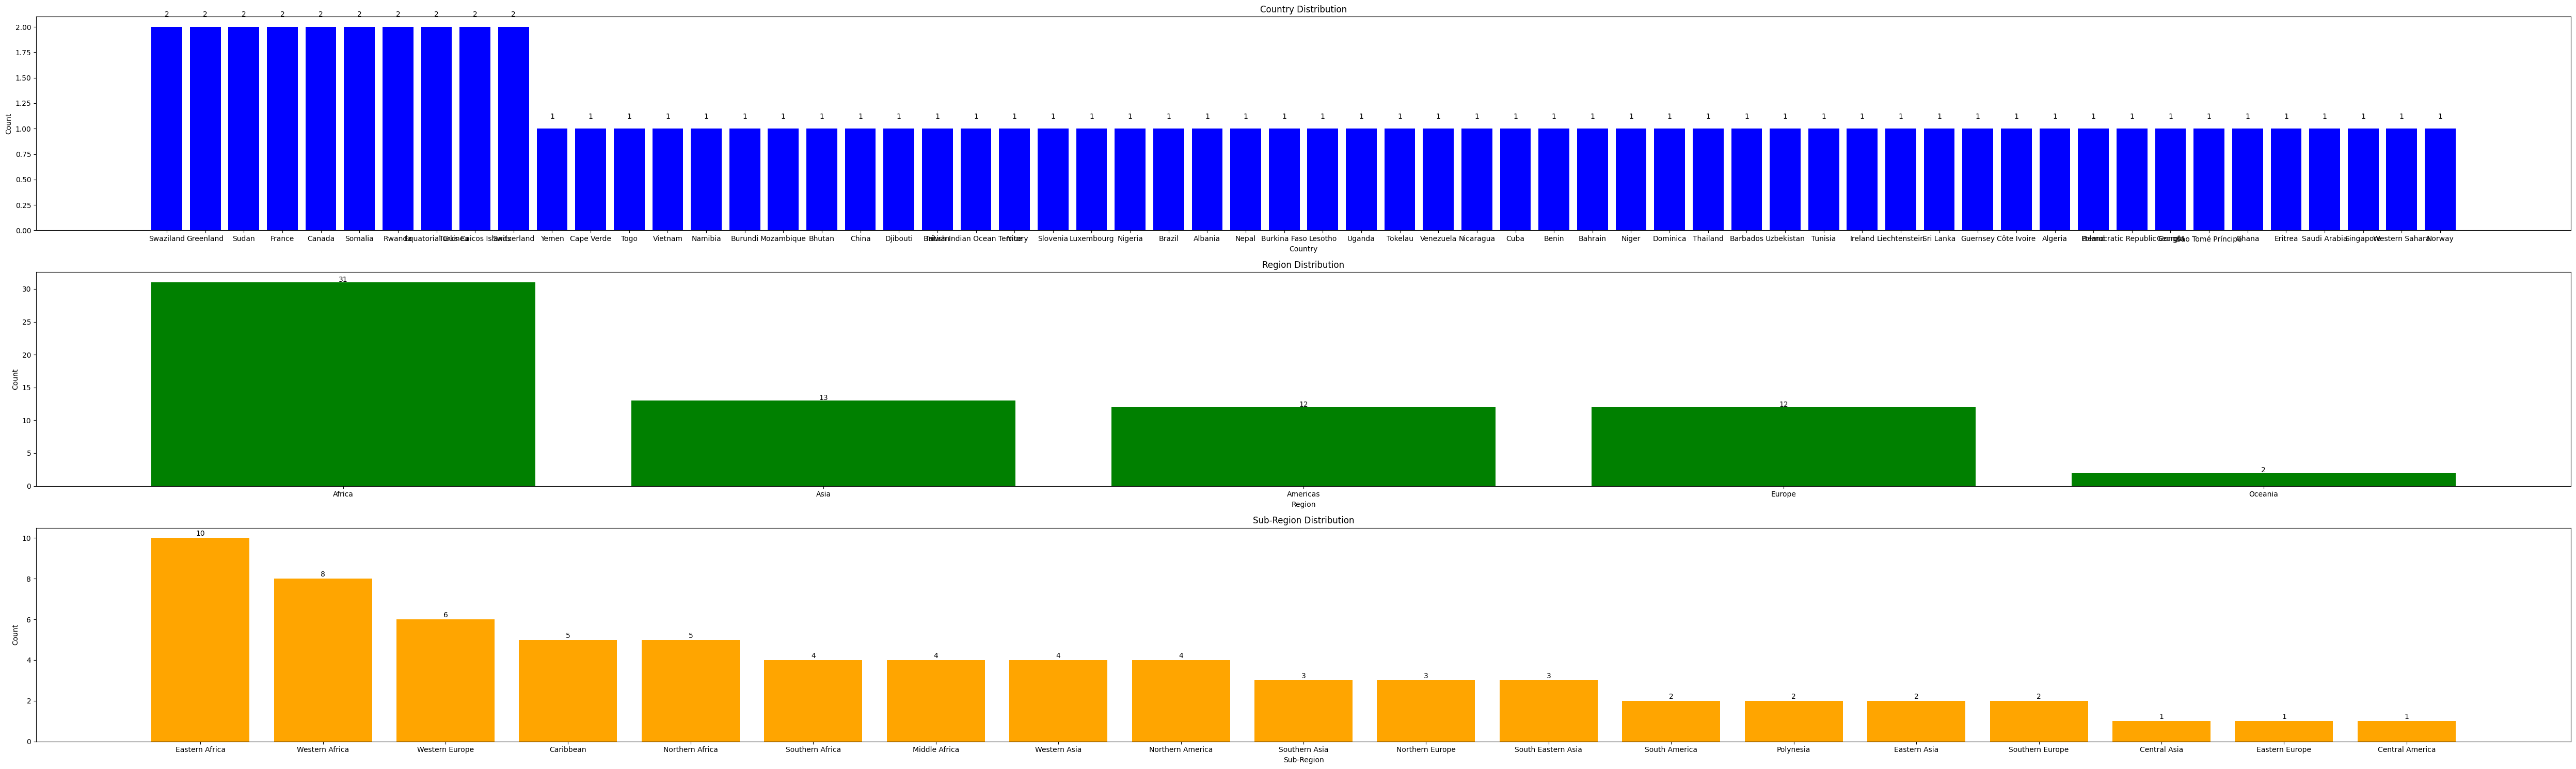

In [64]:
import matplotlib.pyplot as plt


# Calculate value counts for plotting
country_distribution = train_10_15_df['country'].value_counts()
region_distribution = train_10_15_df['region'].value_counts()
sub_region_distribution = train_10_15_df['sub_region'].value_counts()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(50, 15))

# Plot for Country Distribution
axes[0].bar(country_distribution.index, country_distribution.values, color='blue')
axes[0].set_title('Country Distribution')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Count')
for i, v in enumerate(country_distribution.values):
    axes[0].text(i, v + 0.1, str(v), ha='center')

# Plot for Region Distribution
axes[1].bar(region_distribution.index, region_distribution.values, color='green')
axes[1].set_title('Region Distribution')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Count')
for i, v in enumerate(region_distribution.values):
    axes[1].text(i, v + 0.1, str(v), ha='center')

# Plot for Sub-Region Distribution
axes[2].bar(sub_region_distribution.index, sub_region_distribution.values, color='orange')
axes[2].set_title('Sub-Region Distribution')
axes[2].set_xlabel('Sub-Region')
axes[2].set_ylabel('Count')
for i, v in enumerate(sub_region_distribution.values):
    axes[2].text(i, v + 0.1, str(v), ha='center')

# Show plots
plt.tight_layout()
plt.show()


##### 40-50 samples per country


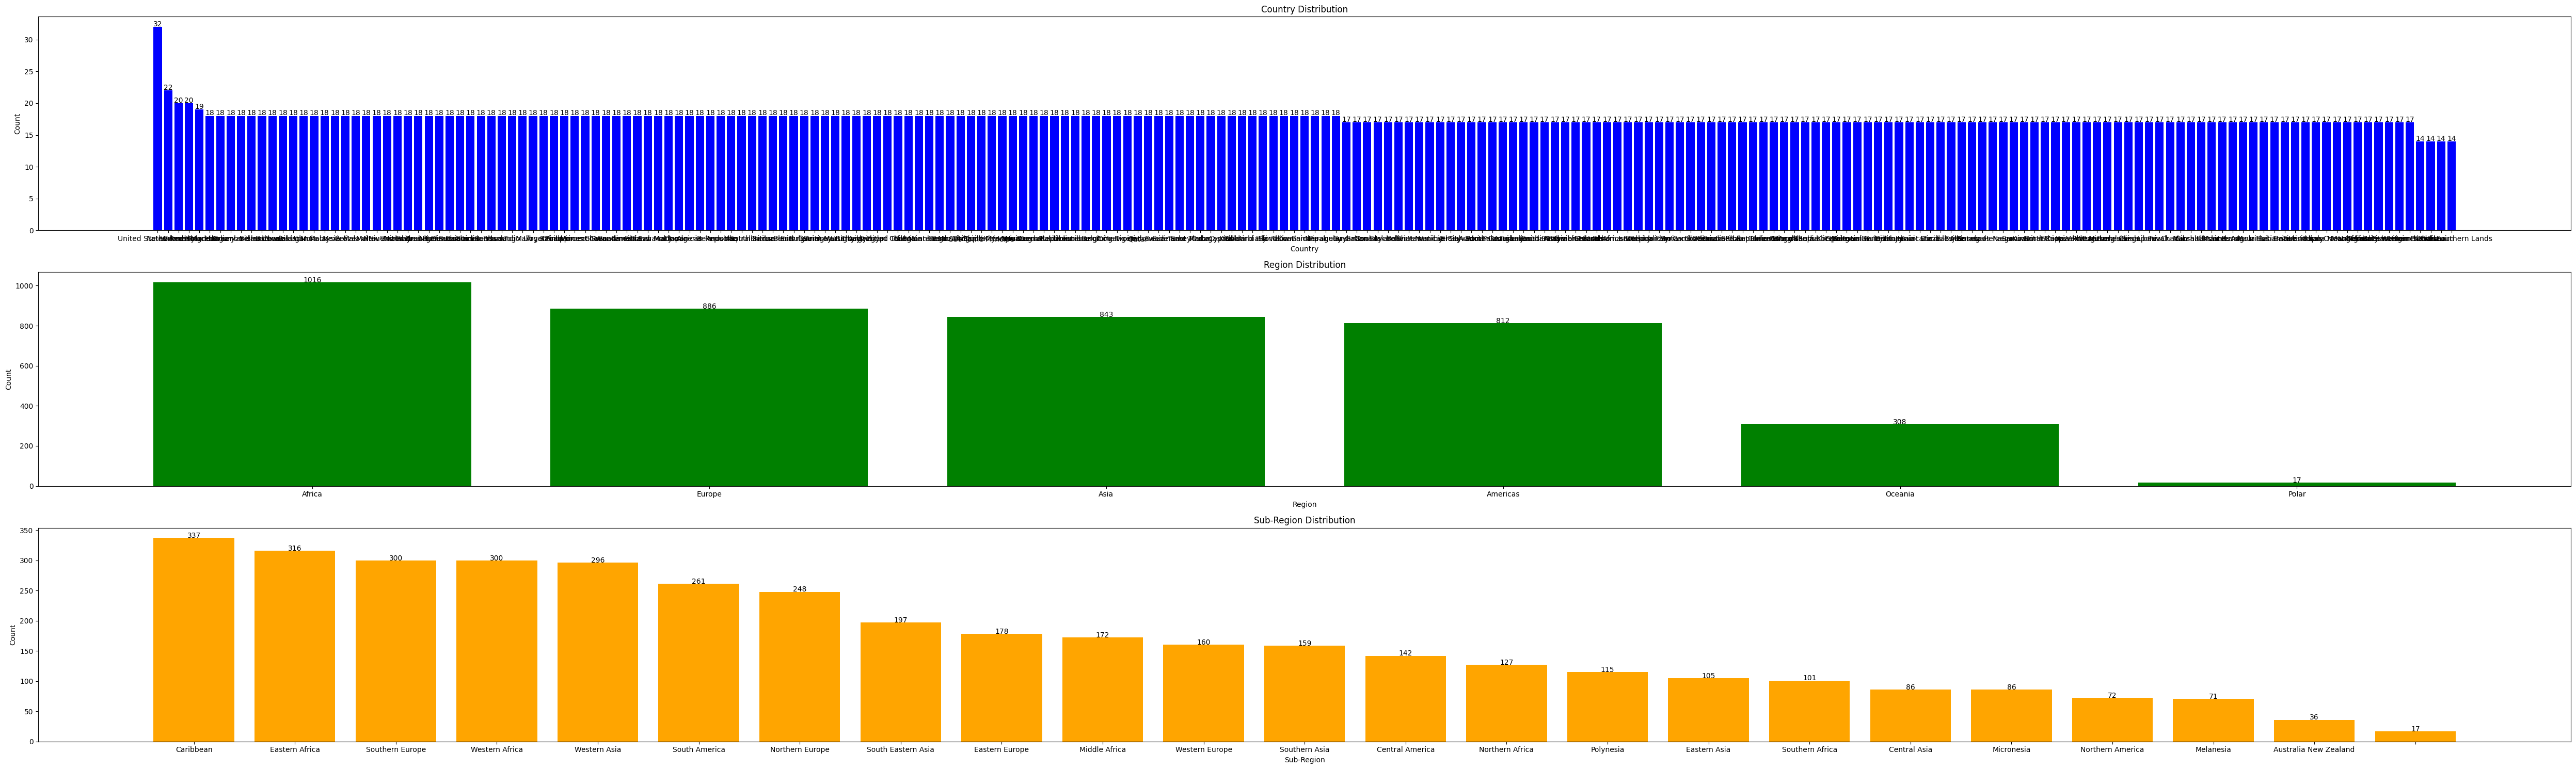

In [61]:

# Calculate value counts for plotting
country_distribution_20_25 = train_20_25_df['country'].value_counts()
region_distribution_20_25 = train_20_25_df['region'].value_counts()
sub_region_distribution_20_25 = train_20_25_df['sub_region'].value_counts()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(50, 15))

# Plot for Country Distribution
axes[0].bar(country_distribution_20_25.index, country_distribution_20_25.values, color='blue')
axes[0].set_title('Country Distribution')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Count')
for i, v in enumerate(country_distribution_20_25.values):
    axes[0].text(i, v + 0.1, str(v), ha='center')

# Plot for Region Distribution
axes[1].bar(region_distribution_20_25.index, region_distribution_20_25.values, color='green')
axes[1].set_title('Region Distribution')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Count')
for i, v in enumerate(region_distribution_20_25.values):
    axes[1].text(i, v + 0.1, str(v), ha='center')

# Plot for Sub-Region Distribution
axes[2].bar(sub_region_distribution_20_25.index, sub_region_distribution_20_25.values, color='orange')
axes[2].set_title('Sub-Region Distribution')
axes[2].set_xlabel('Sub-Region')
axes[2].set_ylabel('Count')
for i, v in enumerate(sub_region_distribution_20_25.values):
    axes[2].text(i, v + 0.1, str(v), ha='center')

# Show plots
plt.tight_layout()
plt.show()

# BASELINE MODELS

## Create the knowledge graph

##### Simple Knowledge graph

In [65]:
def create_knowledge_graph(df):
    G = nx.DiGraph()

    for idx, row in df.iterrows():
        country = row['country']
        location = row['location']
        location_latitude = row['location_latitude']
        location_longitude = row['location_longitude']
        osm_id = row['osm_id']
        region = row['region']
        sub_region = row['sub_region']


        # Add nodes
        if pd.notna(country) and country!= '':
            G.add_node(country, country=country, type='Country')
        if pd.notna(location) and location!= '':
            G.add_node(location, location=location, type='Location', osm_id=osm_id)
        if pd.notna(location_latitude) and location_latitude!= '':
            G.add_node(location_latitude, type='Location_Latitude')
        if pd.notna(location_longitude) and location_longitude!= '':
            G.add_node(location_longitude, type='Location_Longitude')
        if pd.notna(region) and region!= '':
            G.add_node(region, region=region, type='Region')
        if pd.notna(sub_region) and sub_region!= '':
            G.add_node(sub_region, sub_region=sub_region, type='Sub_Region')

        # Add edges
        if (pd.notna(country) and country!='') and (pd.notna(location) and location!=''):
            G.add_edge(country, location, relation='has')
        if (pd.notna(location) and location!='') and (pd.notna(location_latitude) and location_latitude!=''):
            G.add_edge(location, location_latitude, relation='has_latitude')
        if (pd.notna(location) and location!='') and (pd.notna(location_longitude) and location_longitude!=''):
            G.add_edge(location, location_longitude, relation='has_longitude')
        if (pd.notna(country) and country!='') and (pd.notna(region) and region!=''):
            G.add_edge(country, region, relation='is_in')
        if (pd.notna(region) and region!='') and (pd.notna(sub_region) and sub_region!=''):
            G.add_edge(region, sub_region, relation='is_in')

    return G

In [ ]:
# Create the Knowledge Graphs
train_10_15_df_kg = create_knowledge_graph(train_10_15_df)
val_10_15_df_kg = create_knowledge_graph(val_10_15_df)
test_10_15_df_kg = create_knowledge_graph(test_10_15_df)

# 20 25 Samples per country
# Create the Knowledge Graphs
train_20_25_kg = create_knowledge_graph(train_20_25_df)
val_20_25_kg = create_knowledge_graph(val_20_25_df)
test_20_25_kg = create_knowledge_graph(test_20_25_df)

In [ ]:
# Testing
G = create_knowledge_graph(train_20_25_df[:2])
nx.draw(G, with_labels=True)
plt.show()

##### Complex Knowledge Graph

In [15]:
import torch
torch_ver = torch.__version__
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git
  !pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


## Generate embeddings

### Embedding

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from queue import Queue
from threading import Thread
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import networkx as nx
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader

In [200]:
def generate_kge_with_distilbert(graph, batch_size=32):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
    model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased').to('cuda' if torch.cuda.is_available() else 'cpu')

    node_list = list(graph.nodes())
    node_texts = [str(node) for node in node_list]

    # Tokenize in batches
    inputs = tokenizer(node_texts, return_tensors="pt", padding=True, truncation=True)
    input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    node_embeddings = {}

    model.eval()
    with torch.no_grad():
        for i, (input_ids_batch, attention_mask_batch) in enumerate(dataloader):
            input_ids_batch = input_ids_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
            attention_mask_batch = attention_mask_batch.to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            for j in range(cls_embeddings.shape[0]):
                node = node_list[i * batch_size + j]
                node_embeddings[node] = cls_embeddings[j]

    return node_embeddings



In [18]:
#train_10_15_emb = generate_kge_with_distilbert(train_10_15_kg)
#val_10_15_emb = generate_kge_with_distilbert(val_10_15_kg)
#test_10_15_emb = generate_kge_with_distilbert(test_10_15_kg)


#train_20_25_emb = generate_kge_with_distilbert(train_20_25_kg)
#val_20_25_emb = generate_kge_with_distilbert(val_20_25_kg)
#test_20_25_emb = generate_kge_with_distilbert(test_20_25_kg)

In [15]:
len(train_20_25_emb)

23109

In [16]:
len(val_20_25_emb)

3561

In [17]:
len(test_20_25_emb)

3561

## Extract labels and other data

#### Extract data from Graph

In [19]:
def extract_data_from_graph(graph):
    # Initialize dictionaries
    country_labels = []
    location_longitude = []
    location_latitude = []
    node_types = []
    node_type_to_int = {}
    type_counter = 0
    # Collect unique node types from the graph
    unique_node_types = set(graph.nodes[node].get('type', 'Unknown') for node in graph.nodes)
    node_type_to_int = {node_type: i for i, node_type in enumerate(sorted(unique_node_types))}

    for node, data in graph.nodes(data=True):
        node_type = data.get('type', 'Unknown')
        node_types.append(node_type_to_int.get(node_type, 0))
        # Extract country labels if available
        if data.get('type') == 'Country':
            country_labels.append(node)
        # Extract location coordinates if available
        elif data.get('type') == 'Location_Longitude':
            location_longitude.append(node)
        elif data.get('type') == 'Location_Latitude':
            location_latitude.append(node)

    unique_countries = list(set(country_labels))
    country_to_int = {country: i for i, country in enumerate(unique_countries)}
    country_labels = [country_to_int[name] for name in country_labels]

    return {
            'country_labels':country_labels,
            'location_latitudes':location_latitude,
            'location_longitudes':location_longitude,
            'node_types':node_types,
            'node_type_to_int':node_type_to_int
            }


In [30]:
# 10 15
#labels_10_15_train = extract_data_from_graph(train_kg)
#labels_10_15_val = extract_data_from_graph(val_kg)
#labels_10_15_test = extract_data_from_graph(test_kg)

# 40 50
labels_20_25_train = extract_data_from_graph(train_20_25_kg)
labels_20_25_val = extract_data_from_graph(val_20_25_kg)
labels_20_25_test = extract_data_from_graph(test_20_25_kg)

In [21]:
len(labels_20_25_test['location_longitudes'])

1104

In [27]:
labels_20_25_test['location_longitudes'][:3]

[-2.507036, 42.2163889, 14.6832139]

## Create PyG dataset

In [22]:
import torch
from torch_geometric.data import Data, Dataset

class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

def create_pyg_dataset(graph, embeddings, labels):
    data_list = []

    # Create a mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

    # Create edge index tensor
    edge_index = []
    for edge in graph.edges():
        src, dst = edge
        edge_index.append((node_to_idx[src], node_to_idx[dst]))
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create node feature tensor from embeddings
    num_nodes = len(graph.nodes())
    embedding_dim = next(iter(embeddings.values())).shape[0]
    x = torch.zeros(num_nodes, embedding_dim)
    for node, idx in node_to_idx.items():
        x[idx] = torch.tensor(embeddings[node], dtype=torch.float)

    # Create label tensors
    y = torch.zeros(num_nodes, 2)  # Assuming 2D coordinates (latitude, longitude)

    for node, idx in node_to_idx.items():
        if labels.get(node):
            y[idx] = torch.tensor(labels[node], dtype=torch.float)

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

    return CustomDataset(data_list)


In [31]:
# 10 15
#train_10_15_dataset = create_pyg_dataset(train_10_15_kg, train_10_15_emb, labels_10_15_train)
#val_10_15_dataset = create_pyg_dataset(val_10_15_kg, val_10_15_emb, labels_10_15_val)
#test_10_15_dataset = create_pyg_dataset(test_10_15_kg, test_10_15_emb, labels_10_15_test)

# 40 50
train_20_25_dataset = create_pyg_dataset(train_20_25_kg, train_20_25_emb, labels_20_25_train)
val_20_25_dataset = create_pyg_dataset(val_20_25_kg, val_20_25_emb, labels_20_25_val)
test_20_25_dataset = create_pyg_dataset(test_20_25_kg, test_20_25_emb, labels_20_25_test)

In [19]:
def create_pyg_dataset_complexe(graph, embeddings):
    data_list = []

    # Extract data from graph
    extracted_data = extract_data_from_graph(graph)
    location_latitudes = extracted_data['location_latitudes']
    location_longitudes = extracted_data['location_longitudes']

    # Create a mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

    # Create edge index tensor
    edge_index = []
    for edge in graph.edges():
        src, dst = edge
        edge_index.append((node_to_idx[src], node_to_idx[dst]))
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create node feature tensor from embeddings
    num_nodes = len(graph.nodes())
    embedding_dim = next(iter(embeddings.values())).shape[0]
    x = torch.zeros(num_nodes, embedding_dim)
    for node, idx in node_to_idx.items():
        print(node)
        x[idx] = torch.tensor(embeddings[node], dtype=torch.float)

    # Create label tensors for latitude and longitude
    y_lat = torch.zeros(num_nodes, 1)  # Latitude
    y_lon = torch.zeros(num_nodes, 1)  # Longitude

    for node, idx in node_to_idx.items():
        if node in location_latitudes:
            y_lat[idx] = torch.tensor(float(node), dtype=torch.float)
        if node in location_longitudes:
            y_lon[idx] = torch.tensor(float(node), dtype=torch.float)

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, y_lat=y_lat, y_lon=y_lon)
    data_list.append(data)

    return CustomDataset(data_list)

## Build Lat Lon labels

In [25]:
def build_lat_lon_labels(df):
  labels = {}
  for idx, row in df.iterrows():
    location = row['location']
    location_latitude = row['location_latitude']
    location_longitude = row['location_longitude']

    if pd.notna(location) and pd.notna(location_latitude) and pd.notna(location_longitude):
        labels[location] = [location_latitude, location_longitude]
  return labels


In [26]:
# 10 15
#labels_train = build_lat_lon_labels(train_df)
#labels_val = build_lat_lon_labels(val_df)
#labels_test = build_lat_lon_labels(test_df)

# 40 50
#labels_20_25_train = build_lat_lon_labels(train_20_25_df)
#labels_20_25_val = build_lat_lon_labels(val_20_25_df)
#labels_20_25_test = build_lat_lon_labels(test_20_25_df)

## GCN  Models

#### Simple GCN

In [32]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Define the GCN model
class BaselineGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes=2):
        super(BaselineGCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.fc(x)

        return x

##### Hyperparameters tuning

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


which_data ='20_25'
if which_data == '10_15':
  # Assume dataset is your PyG dataset and it has been split into train_dataset, val_dataset, and test_dataset
  train_loader = DataLoader(train_10_15_dataset, batch_size=8, shuffle=True)
  val_loader = DataLoader(val_10_15_dataset, batch_size=8, shuffle=False)
  test_loader = DataLoader(test_10_15_dataset, batch_size=8, shuffle=False)
  test_data = test_10_15_dataset.get(0).to(device)#######################
  num_classes = 2
  num_features = train_10_15_dataset.get(0).num_features


  # Initialize model, optimizer, and data loader
  num_features = train_10_15_dataset.num_features
  num_classes = 2  # For latitude and longitude
elif which_data == '20_25':
  # Assume dataset is your PyG dataset and it has been split into train_dataset, val_dataset, and test_dataset
  train_loader = DataLoader(train_20_25_dataset, batch_size=8, shuffle=True)
  val_loader = DataLoader(val_20_25_dataset, batch_size=8, shuffle=False)
  test_loader = DataLoader(test_20_25_dataset, batch_size=8, shuffle=False)
  test_data = test_20_25_dataset.get(0).to(device)#######################
  num_classes = 2
  num_features = train_20_25_dataset.get(0).num_features



In [35]:
import optuna

# Objective function to optimize
def objective(trial):
    # Hyperparameters to tune

    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    optimizer = trial.suggest_categorical("optimizer",['adam', 'sgd', 'rmsprop', 'adagrad'])
    scheduler = trial.suggest_categorical("scheduler",['none', 'step', 'cos'])
    num_epochs = trial.suggest_int("num_epochs", 100, 100, 500)
    # Initialize and train GCN model
    model = BaselineGCN(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(50):  # Fixed number of epochs
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)  # Assuming regression problem
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        for batch in val_loader:
            batch.to(device)
            with torch.no_grad():
                pred = model(batch)
                loss = F.mse_loss(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs
        val_loss /= len(val_loader.dataset)

        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
best_trial_GCN = study.best_trial

print(f"Value: {best_trial_GCN.value}")
print("Params: ")
for key, value in best_trial_GCN.params.items():
    print(f"    {key}: {value}")



[I 2023-09-28 12:15:53,509] A new study created in memory with name: no-name-efdde81f-c2aa-4ac1-b0ef-df6cf18c26fb
[I 2023-09-28 12:15:55,506] Trial 0 finished with value: 0.0009764825226739049 and parameters: {'lr': 0.0001344005427874589, 'dropout': 0.32524478321287525, 'optimizer': 'adam', 'scheduler': 'cos', 'num_epochs': 100}. Best is trial 0 with value: 0.0009764825226739049.
[I 2023-09-28 12:15:57,387] Trial 1 finished with value: 0.0008093542419373989 and parameters: {'lr': 0.00047301092808742614, 'dropout': 0.3780346616467425, 'optimizer': 'adagrad', 'scheduler': 'cos', 'num_epochs': 100}. Best is trial 1 with value: 0.0008093542419373989.
[I 2023-09-28 12:15:59,247] Trial 2 finished with value: 0.01242071483284235 and parameters: {'lr': 0.03724525841282103, 'dropout': 0.21323930222476634, 'optimizer': 'sgd', 'scheduler': 'cos', 'num_epochs': 100}. Best is trial 1 with value: 0.0008093542419373989.
[I 2023-09-28 12:16:01,239] Trial 3 finished with value: 0.0009356372174806893 an

Number of finished trials: 100
Best trial:
Value: 0.00029869095305912197
Params: 
    lr: 0.0007814125780556324
    dropout: 0.4643646397349001
    optimizer: adagrad
    scheduler: cos
    num_epochs: 100


##### Training

In [37]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

In [38]:
best_trial_GCN = study.best_trial
best_lr_GCN = best_trial_GCN.params['lr']
best_dropout_GCN = best_trial_GCN.params['dropout']
best_optimizer_GCN = best_trial_GCN.params['optimizer']
best_scheduler_GCN = best_trial_GCN.params['scheduler']
num_epochs_GCN = best_trial_GCN.params['num_epochs']

'adagrad'

Training: 100%|██████████| 100/100 [00:03<00:00, 26.19epoch/s]


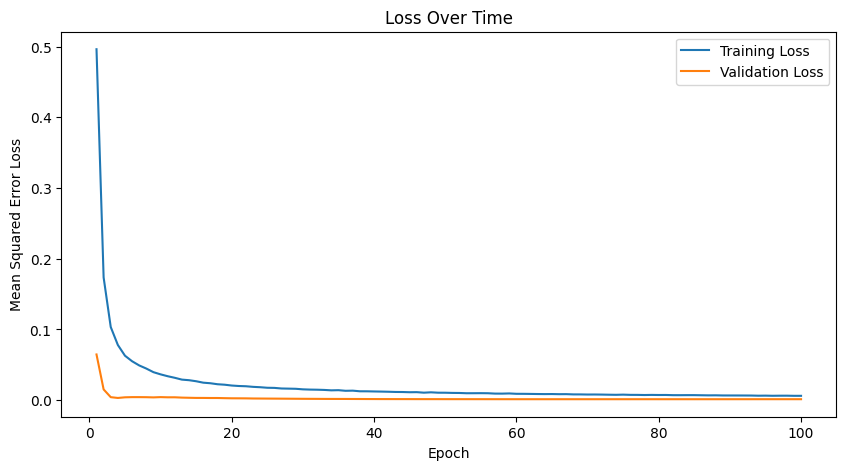

Test Loss: 0.001331488718278706


In [41]:
model_BaselineGCN = BaselineGCN(num_features, num_classes).to(device)

if best_optimizer_GCN == 'adam':
    optimizer = torch.optim.Adam(model_BaselineGCN.parameters(), lr=best_lr_GCN)
elif best_optimizer_GCN == 'sgd':
    optimizer = torch.optim.SGD(model_BaselineGCN.parameters(), lr=best_lr_GCN)
elif best_optimizer_GCN == 'rmsprop':
    optimizer = torch.optim.RMSprop(model_BaselineGCN.parameters(), lr=best_lr_GCN)
elif best_optimizer_GCN == 'adagrad':
    optimizer = torch.optim.Adagrad(model_BaselineGCN.parameters(), lr=best_lr_GCN)


if best_scheduler_GCN == 'step':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
elif best_scheduler_GCN == 'cos':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
elif best_scheduler_GCN == 'none':
    scheduler = None



train_loss_values = []
val_loss_values = []


for epoch in tqdm(range(num_epochs_GCN), desc="Training", unit="epoch"):
    model_BaselineGCN.train()
    train_epoch_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model_BaselineGCN(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item() * batch.num_graphs

    train_epoch_loss /= len(train_loader.dataset)
    train_loss_values.append(train_epoch_loss)

    # Validation loop
    model_BaselineGCN.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model_BaselineGCN(batch)
            loss = F.mse_loss(out, batch.y)
            val_epoch_loss += loss.item() * batch.num_graphs

    val_epoch_loss /= len(val_loader.dataset)
    val_loss_values.append(val_epoch_loss)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs_GCN + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, num_epochs_GCN + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

# Testing loop
model_BaselineGCN.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model_BaselineGCN(batch)
        loss = F.mse_loss(out, batch.y)
        test_loss += loss.item() * batch.num_graphs

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")


##### Testing

#####  Descriptive Statistics Of the model with haversine_distances

In [42]:
from math import radians, sin, cos, sqrt, atan2
import numpy as np
from scipy import stats

def haversine_distance(coord1, coord2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model_BaselineGCN.eval()
with torch.no_grad():
    predictions = model_BaselineGCN(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions)
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")

MAE: 0.03174419328570366, 
MSE: 0.0013314880197867751, 
RMSE: 0.03648956120014191, 
R-Squared: 0.0


In [44]:
# Calculate Haversine distances for all nodes
haversine_distances = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions)])

mean_distance = np.mean(haversine_distances)
median_distance = np.median(haversine_distances)
std_dev = np.std(haversine_distances)
min_distance = np.min(haversine_distances)
max_distance = np.max(haversine_distances)
quartiles = np.percentile(haversine_distances, [25, 50, 75])
skewness = stats.skew(haversine_distances)
kurtosis = stats.kurtosis(haversine_distances)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

Mean: 5.583720380438119, Median: 5.621790252367003, Std Dev: 1.322099798437052
Min: 1.5306593941342002, Max: 37.3828540255648
Quartiles: [4.98954764 5.62179025 6.18313703]
Skewness: 9.124437761270974, Kurtosis: 190.92954895624203


### Robust GCN


1. **Deeper Network**: Add more layers to capture more complex features.
2. **Batch Normalization**: Normalize the activations of the neurons in the hidden layers.
3. **Skip Connections**: Add skip connections to help the gradient flow during backpropagation.
4. **Different Activation Functions**: Use different activation functions like Leaky ReLU or Parametric ReLU.
5. **Regularization**: Add L2 regularization to the fully connected layers.


In [45]:
from torch_geometric.nn import  BatchNorm

class RobustGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(RobustGCN, self).__init__()
        self.conv1 = GCNConv(num_features, 256)
        self.bn1 = BatchNorm(256)

        self.conv2 = GCNConv(256, 128)
        self.bn2 = BatchNorm(128)

        self.conv3 = GCNConv(128, 64)
        self.bn3 = BatchNorm(64)

        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, num_classes)

        self.dropout = 0.5  # Dropout rate
        self.reg_lambda = 0.001  # L2 regularization

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Fully connected layers
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.fc2(x)

        # L2 regularization
        l2_reg = torch.tensor(0.).to(x.device)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        x += self.reg_lambda * l2_reg

        return x

#### Hyperparameters fine tuning

In [46]:
def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_epochs = trial.suggest_int("num_epochs", 100, 400, 100)

    # Initialize and train the model_RobustGCN
    model_RobustGCN = RobustGCN(num_features, num_classes).to(device)
    model_RobustGCN.dropout = dropout
    model_RobustGCN.reg_lambda = reg_lambda

    optimizer = torch.optim.Adam(model_RobustGCN.parameters(), lr=lr)


    for epoch in range(num_epochs):  # Modified this line to use num_epochs
        model_RobustGCN.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model_RobustGCN(batch)
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluate the model_RobustGCN
    model_RobustGCN.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:  # Assuming val_loader is your validation DataLoader
            batch.to(device)
            out = model_RobustGCN(batch)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
best_rgcn_trial = study.best_trial

print(f"Value: {best_rgcn_trial.value}")
print(f"Params: ")
for key, value in best_rgcn_trial.params.items():
    print(f"    {key}: {value}")


[I 2023-09-28 12:25:02,136] A new study created in memory with name: no-name-4c09e662-026f-49be-8445-a85680dc8300
[I 2023-09-28 12:25:09,293] Trial 0 finished with value: 1.844660459937586e-06 and parameters: {'lr': 0.07600047099887107, 'dropout': 0.44173310531079657, 'reg_lambda': 7.713263287747527e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 0 with value: 1.844660459937586e-06.
[I 2023-09-28 12:25:24,197] Trial 1 finished with value: 0.002527236472815275 and parameters: {'lr': 1.943468813265777e-05, 'dropout': 0.25274391798375057, 'reg_lambda': 0.00024723370837235564, 'batch_size': 16, 'num_epochs': 400}. Best is trial 0 with value: 1.844660459937586e-06.
[I 2023-09-28 12:25:32,215] Trial 2 finished with value: 0.0005363397649489343 and parameters: {'lr': 0.0007686248056161942, 'dropout': 0.49624133814824134, 'reg_lambda': 0.0003919284448870682, 'batch_size': 64, 'num_epochs': 200}. Best is trial 0 with value: 1.844660459937586e-06.
[I 2023-09-28 12:25:35,967] Trial 3 fin

Number of finished trials: 100
Best trial:
Value: 1.521004122650993e-08
Params: 
    lr: 0.020391522110256237
    dropout: 0.4406415125417341
    reg_lambda: 6.517506210671125e-05
    batch_size: 64
    num_epochs: 400


In [47]:
best_rgcn_trial = study.best_trial
best_rgcn_lr = best_rgcn_trial.params['lr']
best_rgcn_dropout = best_rgcn_trial.params['dropout']
best_rgcn_optimizer = best_rgcn_trial.params['reg_lambda']
best_rgcn_batch_size = best_rgcn_trial.params['batch_size']
best_rgcn_num_epochs = best_rgcn_trial.params['num_epochs']

#### Training & Testing

Training: 100%|██████████| 400/400 [00:18<00:00, 21.63epoch/s]


Test Loss: 1.1726918813792508e-07


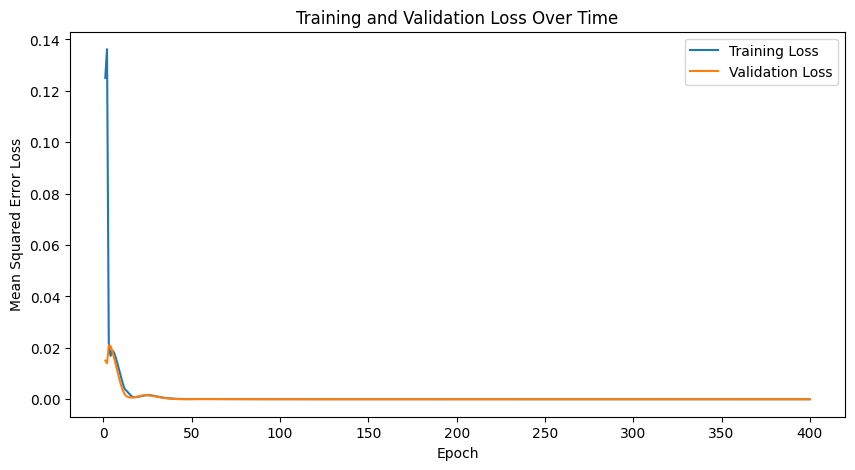

In [50]:
from torch_geometric.nn import GCNConv, BatchNorm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm


model_RobustGCN = RobustGCN(num_features, num_classes).to(device)
optimizer_RobustGCN = torch.optim.Adam(model_RobustGCN.parameters(), lr=best_rgcn_lr, weight_decay=best_rgcn_optimizer)
scheduler_RobustGCN = lr_scheduler.StepLR(optimizer_RobustGCN, step_size=50, gamma=0.7)  # Assuming StepLR, you can replace this

# Training loop
train_loss_values = []
val_loss_values = []
for epoch in tqdm(range(best_rgcn_num_epochs), desc="Training", unit="epoch"):  # 300 epochs
    model_RobustGCN.train()
    train_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer_RobustGCN.zero_grad()
        out = model_RobustGCN(batch)
        loss = F.mse_loss(out, batch.y)  # Using Mean Squared Error loss for regression
        loss.backward()
        optimizer_RobustGCN.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    # Validation loop
    model_RobustGCN.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model_RobustGCN(batch)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)

    # Update the learning rate
    scheduler_RobustGCN.step()

    #print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Test loop
model_RobustGCN.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model_RobustGCN(batch)
        loss = F.mse_loss(out, batch.y)
        test_loss += loss.item()
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, best_rgcn_num_epochs+1), train_loss_values, label='Training Loss')
plt.plot(range(1, best_rgcn_num_epochs+1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()



####  Descriptive Statistics Of the model test result

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model_RobustGCN.eval()
with torch.no_grad():
    predictions_RobustGCN = model_RobustGCN(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions_RobustGCN)
mse = mean_squared_error(labels, predictions_RobustGCN)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions_RobustGCN)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")

MAE: 0.00025332049699500203, 
MSE: 1.1726923787591659e-07, 
RMSE: 0.00034244597190991044, 
R-Squared: 0.0


In [52]:
# Calculate Haversine distances for all nodes
haversine_distances_RobustGCN = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions_RobustGCN)])

mean_distance = np.mean(haversine_distances_RobustGCN)
median_distance = np.median(haversine_distances_RobustGCN)
std_dev = np.std(haversine_distances_RobustGCN)
min_distance = np.min(haversine_distances_RobustGCN)
max_distance = np.max(haversine_distances_RobustGCN)
quartiles = np.percentile(haversine_distances_RobustGCN, [25, 50, 75])
skewness = stats.skew(haversine_distances_RobustGCN)
kurtosis = stats.kurtosis(haversine_distances_RobustGCN)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

Mean: 0.04039315511188404, Median: 0.024402545427596626, Std Dev: 0.035613176701708334
Min: 6.054090310167454e-05, Max: 0.1850366701787437
Quartiles: [0.01356079 0.02440255 0.06300689]
Skewness: 1.0197937465608402, Kurtosis: -0.1239864157048407


## GraphSage Model

### Simple GraphSage


1. Deeper Network: Added more GraphSAGE layers.
2. Batch Normalization: Used to normalize the activations.
3. Skip Connections: Added to help the gradient flow.
4. Different Activation Functions: Used Leaky ReLU.
5. Regularization: Added L2 regularization to the fully connected layers.

To use L2 regularization during training, there is a need to add the regularization loss the main loss as follows:

```python
weight_decay = 0.01  
loss = F.mse_loss(out, batch.y) + model.get_reg_loss(weight_decay)
```


In [53]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, num_classes, conv1_out_channels=128, conv2_out_channels=64, dropout_rate=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, conv1_out_channels)
        self.conv2 = SAGEConv(conv1_out_channels, conv2_out_channels)
        self.fc = torch.nn.Linear(conv2_out_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc(x)
        return x


##### Hyperparameters fine tuning

In [55]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Hyperparameter
    conv1_out_channels = trial.suggest_int('conv1_out_channels', 64, 256)
    conv2_out_channels = trial.suggest_int('conv2_out_channels', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.8)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_epochs = trial.suggest_int('num_epochs', 50, 200)

    # Initialize model, optimizer, and other components
    model = GraphSAGE(num_features, num_classes, conv1_out_channels, conv2_out_channels, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()  # or another appropriate loss function


    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        for batch in val_loader:
            with torch.no_grad():
                out = model(batch)
                loss = criterion(out, batch.y)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Optuna prunes unpromising trials
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial: {study.best_trial.params}")


[I 2023-09-28 12:58:30,796] A new study created in memory with name: no-name-cdd520c1-07e1-4dea-af48-f5fb806432ad
[I 2023-09-28 12:58:48,200] Trial 0 finished with value: 0.0 and parameters: {'conv1_out_channels': 153, 'conv2_out_channels': 128, 'dropout_rate': 0.6099700681082947, 'lr': 0.008810851089066004, 'num_epochs': 120}. Best is trial 0 with value: 0.0.
[I 2023-09-28 12:58:59,249] Trial 1 finished with value: 0.0 and parameters: {'conv1_out_channels': 144, 'conv2_out_channels': 96, 'dropout_rate': 0.6050434924623029, 'lr': 0.07847367929735825, 'num_epochs': 84}. Best is trial 0 with value: 0.0.
[I 2023-09-28 12:59:06,852] Trial 2 finished with value: 0.0 and parameters: {'conv1_out_channels': 83, 'conv2_out_channels': 91, 'dropout_rate': 0.36065567377132596, 'lr': 0.08614921374921969, 'num_epochs': 76}. Best is trial 0 with value: 0.0.
[I 2023-09-28 12:59:24,328] Trial 3 finished with value: 0.0 and parameters: {'conv1_out_channels': 126, 'conv2_out_channels': 64, 'dropout_rate'

Number of finished trials: 100
Best trial: {'conv1_out_channels': 153, 'conv2_out_channels': 128, 'dropout_rate': 0.6099700681082947, 'lr': 0.008810851089066004, 'num_epochs': 120}


##### Best parameters

In [ ]:
best_gsge_trial = study.best_trial
best_gsge_conv1_out_channels = best_gsge_trial.suggest_int('conv1_out_channels', 64, 256)
best_gsge_conv2_out_channels = best_gsge_trial.suggest_int('conv2_out_channels', 32, 128)
best_gsge_dropout_rate = best_gsge_trial.suggest_float('dropout_rate', 0.2, 0.8)
best_gsge_lr = best_gsge_trial.suggest_float('lr', 1e-5, 1e-1, log=True)
best_gsge_num_epochs = best_gsge_trial.suggest_int('num_epochs', 50, 200)

##### Training & Validation

In [ ]:
# Initialize model_GraphSAGE with best parameters
model_GraphSAGE = GraphSAGE(num_features, num_classes, best_gsge_conv1_out_channels, best_gsge_conv2_out_channels, best_gsge_dropout_rate)

# Initialize optimizer_GraphSAGE with best learning rate
optimizer_GraphSAGE = torch.optim.Adam(model_GraphSAGE.parameters(), lr=best_gsge_lr)

# Loss function
criterion_GraphSAGE = torch.nn.CrossEntropyLoss()


# Training loop
for epoch in range(best_gsge_num_epochs):
    model_GraphSAGE.train()
    for batch in train_loader:
        optimizer_GraphSAGE.zero_grad()
        out = model_GraphSAGE(batch)
        loss = criterion_GraphSAGE(out, batch.y)
        loss.backward()
        optimizer_GraphSAGE.step()

    # Validation
    model_GraphSAGE.eval()
    val_loss = 0
    for batch in val_loader:
        with torch.no_grad():
            out = model_GraphSAGE(batch)
            loss = criterion_GraphSAGE(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Epoch: {epoch+1}, Val Loss: {val_loss}")



##### Testing

In [ ]:
# Testing
model_GraphSAGE.eval()
test_loss = 0
for batch in test_loader:
    with torch.no_grad():
        out = model_GraphSAGE(batch)
        loss = criterion_GraphSAGE(out, batch.y)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

##### Statistic of test results

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model_GraphSAGE.eval()
with torch.no_grad():
    predictions_GraphSAGE = model_GraphSAGE(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions_GraphSAGE)
mse = mean_squared_error(labels, predictions_GraphSAGE)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions_GraphSAGE)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")

In [ ]:
# Calculate Haversine distances for all nodes
haversine_distances_GraphSAGE = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions_GraphSAGE)])

mean_distance = np.mean(haversine_distances_GraphSAGE)
median_distance = np.median(haversine_distances_GraphSAGE)
std_dev = np.std(haversine_distances_GraphSAGE)
min_distance = np.min(haversine_distances_GraphSAGE)
max_distance = np.max(haversine_distances_GraphSAGE)
quartiles = np.percentile(haversine_distances_GraphSAGE, [25, 50, 75])
skewness = stats.skew(haversine_distances_GraphSAGE)
kurtosis = stats.kurtosis(haversine_distances_GraphSAGE)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

### AdvancedGraphSAGE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class AdvancedGraphSAGE(nn.Module):
    def __init__(self, num_features, num_classes, conv1_out_channels=128, conv2_out_channels=128, conv3_out_channels=64, conv4_out_channels=64, dropout_rate=0.5):
        super(AdvancedGraphSAGE, self).__init__()

        self.conv1 = SAGEConv(num_features, conv1_out_channels)
        self.bn1 = nn.BatchNorm1d(conv1_out_channels)

        self.conv2 = SAGEConv(conv1_out_channels, conv2_out_channels)
        self.bn2 = nn.BatchNorm1d(conv2_out_channels)

        self.conv3 = SAGEConv(conv2_out_channels, conv3_out_channels)
        self.bn3 = nn.BatchNorm1d(conv3_out_channels)

        self.conv4 = SAGEConv(conv3_out_channels, conv4_out_channels)
        self.bn4 = nn.BatchNorm1d(conv4_out_channels)

        self.fc = nn.Linear(conv4_out_channels, num_classes)

        self.dropout_rate = dropout_rate
        self.reg_loss = nn.MSELoss()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=self.dropout_rate, training=self.training)

        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2 + x1)
        x2 = F.dropout(x2, p=self.dropout_rate, training=self.training)

        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.leaky_relu(x3)
        x3 = F.dropout(x3, p=self.dropout_rate, training=self.training)

        x4 = self.conv4(x3, edge_index)
        x4 = self.bn4(x4)
        x4 = F.leaky_relu(x4 + x3)
        x4 = F.dropout(x4, p=self.dropout_rate, training=self.training)

        out = self.fc(x4)

        return out

    def get_reg_loss(self, weight_decay):
        reg_loss = 0.0
        for param in self.fc.parameters():
            reg_loss += self.reg_loss(param, torch.zeros_like(param))
        return weight_decay * reg_loss


#### Hyperparameters fine tuning

In [ ]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    conv1_out_channels = trial.suggest_int('conv1_out_channels', 64, 256)
    conv2_out_channels = trial.suggest_int('conv2_out_channels', 64, 256)
    conv3_out_channels = trial.suggest_int('conv3_out_channels', 32, 128)
    conv4_out_channels = trial.suggest_int('conv4_out_channels', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.8)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    num_epochs = trial.suggest_int('num_epochs', 50, 200)

    # Initialize and train your model here using the suggested hyperparameters
    # Make sure to return the validation loss
    model_AdvancedGraphSAGE = AdvancedGraphSAGE(num_features, num_classes, conv1_out_channels=trial.suggest_int('conv1_out_channels', 64, 256), conv2_out_channels=trial.suggest_int('conv2_out_channels', 64, 256), conv3_out_channels=trial.suggest_int('conv3_out_channels', 32, 128), conv4_out_channels=trial.suggest_int('conv4_out_channels', 32, 128), dropout_rate=trial.suggest_float('dropout_rate', 0.2, 0.8))
    optimizer = torch.optim.Adam(model_AdvancedGraphSAGE.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model_AdvancedGraphSAGE.train()
        for batch in train_loader:
            optimizer.zero_grad()
            out = model_AdvancedGraphSAGE(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

        # Validation
        model_AdvancedGraphSAGE.eval()
        val_loss = 0
        for batch in val_loader:
            with torch.no_grad():
                out = model_AdvancedGraphSAGE(batch)
                loss = criterion(out, batch.y)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Optuna prunes unpromising trials
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial: {study.best_trial.params}")

# Create a study object and specify the direction is 'minimize'.
study = optuna.create_study(direction='minimize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(objective, n_trials=100)


In [ ]:
# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
best_trial_AdvancedGraphSAGE  = study.best_trial

print('Value: ', best_trial_AdvancedGraphSAGE.value)
print('Params: ')
for key, value in best_trial_AdvancedGraphSAGE.params.items():
    print(f'    {key}: {value}')

In [ ]:
best_agsge_conv1_out_channels = best_trial_AdvancedGraphSAGE.suggest_int('conv1_out_channels', 64, 256)
best_agsge_conv2_out_channels = best_trial_AdvancedGraphSAGE.suggest_int('conv2_out_channels', 64, 256)
best_agsge_conv3_out_channels = best_trial_AdvancedGraphSAGE.suggest_int('conv3_out_channels', 32, 128)
best_agsge_conv4_out_channels = best_trial_AdvancedGraphSAGE.suggest_int('conv4_out_channels', 32, 128)
best_agsge_dropout_rate = best_trial_AdvancedGraphSAGE.suggest_float('dropout_rate', 0.2, 0.8)
best_agsge_lr = best_trial_AdvancedGraphSAGE.suggest_float('lr', 1e-5, 1e-1, log=True)
wbest_agsge_eight_decay = best_trial_AdvancedGraphSAGE.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
best_agsge_num_epochs = best_trial_AdvancedGraphSAGE.suggest_int('num_epochs', 50, 200)

#### Training, Validation & Testing

In [ ]:
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader

# Initialize the model with the best parameters
model_AdvancedGraphSAGE = AdvancedGraphSAGE(
    num_features,
    num_classes,
    conv1_out_channels=best_agsge_conv1_out_channels,
    conv2_out_channels=best_agsge_conv2_out_channels,
    conv3_out_channels=best_agsge_conv3_out_channels,
    conv4_out_channels=best_agsge_conv4_out_channels,
    dropout_rate=best_agsge_dropout_rate
)

# Initialize the optimizer
optimizer = optim.Adam(model_AdvancedGraphSAGE.parameters(), lr=best_agsge_lr, weight_decay=best_agsge_weight_decay)



# Training Loop
for epoch in range(best_agsge_num_epochs):
    model_AdvancedGraphSAGE.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model_AdvancedGraphSAGE(batch)
        loss = F.cross_entropy(out, batch.y) + model_AdvancedGraphSAGE.get_reg_loss(best_agsge_weight_decay)
        loss.backward()
        optimizer.step()

    # Validation Loop
    model_AdvancedGraphSAGE.eval()
    val_loss = 0
    for batch in val_loader:
        with torch.no_grad():
            out = model_AdvancedGraphSAGE(batch)
            val_loss += F.cross_entropy(out, batch.y).item()
    val_loss /= len(val_loader)
    print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")

# Testing Loop
model_AdvancedGraphSAGE.eval()
test_loss = 0
for batch in test_loader:
    with torch.no_grad():
        out = model_AdvancedGraphSAGE(batch)
        test_loss += F.cross_entropy(out, batch.y).item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")


# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 301), train_loss_values, label='Training Loss')
plt.plot(range(1, 301), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


#### Stat test result


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model_AdvancedGraphSAGE.eval()
with torch.no_grad():
    predictions_AdvancedGraphSAGE = model_AdvancedGraphSAGE(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions_AdvancedGraphSAGE)
mse = mean_squared_error(labels, predictions_AdvancedGraphSAGE)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions_AdvancedGraphSAGE)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")

In [ ]:
# Calculate Haversine distances for all nodes
haversine_distances_AdvancedGraphSAGE = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions_AdvancedGraphSAGE)])

mean_distance = np.mean(haversine_distances_AdvancedGraphSAGE)
median_distance = np.median(haversine_distances_AdvancedGraphSAGE)
std_dev = np.std(haversine_distances_AdvancedGraphSAGE)
min_distance = np.min(haversine_distances_AdvancedGraphSAGE)
max_distance = np.max(haversine_distances_AdvancedGraphSAGE)
quartiles = np.percentile(haversine_distances_AdvancedGraphSAGE, [25, 50, 75])
skewness = stats.skew(haversine_distances_AdvancedGraphSAGE)
kurtosis = stats.kurtosis(haversine_distances_AdvancedGraphSAGE)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

## GAT Model

#### Simple GAT Model

In [303]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 128, heads=4, concat=True)
        self.conv2 = GATConv(128 * 4, 64, heads=4, concat=True)
        self.fc = torch.nn.Linear(64 * 4, num_classes)  # num_classes is 2 for latitude and longitude

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        # Second GAT layer
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        # Fully connected layer
        x = self.fc(x)

        return x


##### Hyperparameters fine-tuning

In [304]:
def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.7)
    num_heads = trial.suggest_int("num_heads", 1, 8)
    num_epochs = trial.suggest_int("num_epochs", 50, 200)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Initialize and train your model here
    model = GAT(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    for epoch in range(num_epochs):
        model.train()
        for batch in loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluate your model here
    model.eval()
    with torch.no_grad():
        predictions = model(test_dataset[0]).cpu().numpy()
        labels = test_dataset[0].y.cpu().numpy()
        mae = mean_absolute_error(labels, predictions)

    return mae

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print(f"Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-09-27 15:26:28,890] A new study created in memory with name: no-name-eb3ba49f-0668-4a50-9e45-4da10dde9355
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2023-09-27 15:26:30,139] Trial 0 finished with value: 12.926971435546875 and parameters: {'lr': 0.0002903595487403773, 'dropout': 0.46881094539627666, 'num_heads': 7, 'num_epochs': 71, 'batch_size': 16}. Best is trial 0 with value: 12.926971435546875.
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2023-09-27 15:26:32,530] Trial 1 finished with value: 13.375064849853516 and parameters: {'lr': 0.05387510847980975, 'dropout': 0.2144768553544583, 'num_heads': 2, 'num_epochs': 143, 'batch_size': 64}. Best is trial 0 with value: 12.926971435546875.
/usr/local/lib/python3.10/dist

Number of finished trials: 100
Best trial:
Value: 1.876359462738037
Params: 
    lr: 0.005598489571238161
    dropout: 0.6308090826000773
    num_heads: 8
    num_epochs: 179
    batch_size: 16


##### Training, Validatation and Testing

Epoch 1, Validation Loss: 764.2568359375
Epoch 2, Validation Loss: 757.72802734375
Epoch 3, Validation Loss: 741.50732421875
Epoch 4, Validation Loss: 747.1117553710938
Epoch 5, Validation Loss: 711.9429321289062
Epoch 6, Validation Loss: 689.39306640625
Epoch 7, Validation Loss: 662.2972412109375
Epoch 8, Validation Loss: 654.6044311523438
Epoch 9, Validation Loss: 768.4866943359375
Epoch 10, Validation Loss: 751.2456665039062
Epoch 11, Validation Loss: 664.2169189453125
Epoch 12, Validation Loss: 848.6822509765625
Epoch 13, Validation Loss: 644.5471801757812
Epoch 14, Validation Loss: 619.2442626953125
Epoch 15, Validation Loss: 614.6798095703125
Epoch 16, Validation Loss: 587.637451171875
Epoch 17, Validation Loss: 643.3941650390625
Epoch 18, Validation Loss: 685.2921752929688
Epoch 19, Validation Loss: 633.343994140625
Epoch 20, Validation Loss: 596.6073608398438
Epoch 21, Validation Loss: 597.7876586914062
Epoch 22, Validation Loss: 588.0406494140625
Epoch 23, Validation Loss: 628

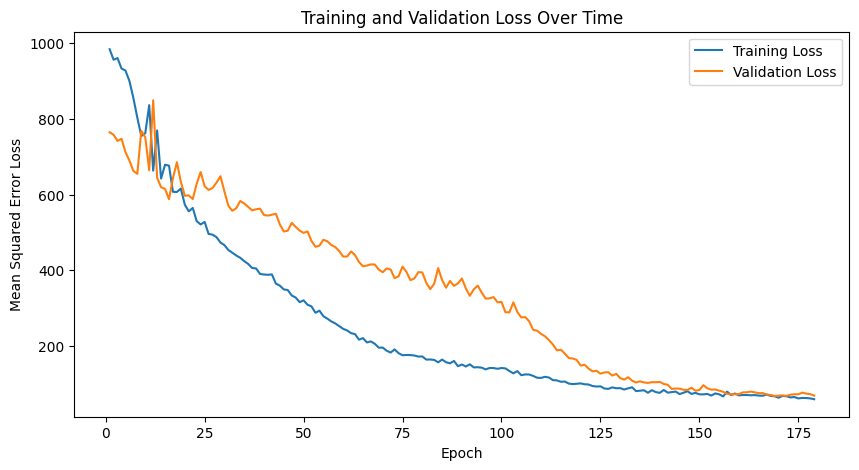

In [306]:
import matplotlib.pyplot as plt

# Best hyperparameters from Optuna
best_lr = trial.params['lr']
best_dropout = trial.params['dropout']
best_num_heads = trial.params['num_heads']
best_num_epochs = trial.params['num_epochs']
best_batch_size = trial.params['batch_size']

# Initialize model and optimizer with best hyperparameters
model_GAT = GAT(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model_GAT.parameters(), lr=best_lr)


# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(best_num_epochs):
    model_GAT.train()
    train_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model_GAT(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model_GAT.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model_GAT(batch)
            val_loss += F.mse_loss(out, batch.y).item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}")

# Testing loop
model_GAT.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model_GAT(batch)
        test_loss += F.mse_loss(out, batch.y).item()
print(f"Test Loss: {test_loss / len(test_loader)}")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, best_num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, best_num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


##### Statistic of test results

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model_GAT.eval()
with torch.no_grad():
    predictions_GAT = model_GAT(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions_GAT)
mse = mean_squared_error(labels, predictions_GAT)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions_GAT)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")

In [ ]:
# Calculate Haversine distances for all nodes
haversine_distances_GAT = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions_GAT)])

mean_distance = np.mean(haversine_distances_GAT)
median_distance = np.median(haversine_distances_GAT)
std_dev = np.std(haversine_distances_GAT)
min_distance = np.min(haversine_distances_GAT)
max_distance = np.max(haversine_distances_GAT)
quartiles = np.percentile(haversine_distances_GAT, [25, 50, 75])
skewness = stats.skew(haversine_distances_GAT)
kurtosis = stats.kurtosis(haversine_distances_GAT)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

#### Robust GAT


1. More layers to capture complex features.
2. Batch normalization to normalize the activations.
3. Skip connections to help the gradient flow.
4. Leaky ReLU activation functions.


In [56]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, BatchNorm

class RobustGAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, n_hidden=128, num_heads=2, dropout_rate=0.5):
        super(RobustGAT, self).__init__()

        self.conv1 = GATConv(num_features, n_hidden, heads=num_heads)
        self.batch_norm1 = torch.nn.BatchNorm1d(n_hidden * num_heads)

        self.conv2 = GATConv(n_hidden * num_heads, n_hidden, heads=num_heads)
        self.batch_norm2 = torch.nn.BatchNorm1d(n_hidden * num_heads)

        # Latitude and Longitude regression layers
        self.fc_coordinates_1 = torch.nn.Linear(n_hidden * num_heads, 256)
        self.fc_coordinates_2 = torch.nn.Linear(256, 128)
        self.fc_coordinates_3 = torch.nn.Linear(128, num_classes)

        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm_coordinates = torch.nn.BatchNorm1d(256)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GAT layer
        x1 = F.leaky_relu(self.conv1(x, edge_index))
        x1 = self.batch_norm1(x1)
        x1 = self.dropout(x1)

        # Second GAT layer
        x2 = F.leaky_relu(self.conv2(x1, edge_index))
        x2 = self.batch_norm2(x2)
        x2 = self.dropout(x2)

        # Skip Connection
        x = x1 + x2

        # Latitude and Longitude regression
        coordinates = F.leaky_relu(self.fc_coordinates_1(x))
        coordinates = self.batch_norm_coordinates(coordinates)
        coordinates = self.dropout(coordinates)

        coordinates = F.leaky_relu(self.fc_coordinates_2(coordinates))
        coordinates = self.fc_coordinates_3(coordinates)

        return coordinates


##### Hyperparameters fin tuning

In [58]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    n_hidden = trial.suggest_int("n_hidden", 64, 256)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_epochs = trial.suggest_int("num_epochs", 10, 100)

    # Initialize and train the model
    model = RobustGAT(num_features, num_classes, n_hidden=n_hidden, num_heads=num_heads, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Assuming train_dataset is your training dataset

    for epoch in range(num_epochs):
        model.train()
        for batch in loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)  # Assuming a regression problem; change the loss function if needed
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:  # Assuming val_loader is your validation DataLoader
            batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print(f"Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-09-27 23:13:08,509] A new study created in memory with name: no-name-c61c0825-3df7-4916-a74d-9a99ce8ec3b9
[I 2023-09-27 23:13:11,574] Trial 0 finished with value: 39.76555633544922 and parameters: {'lr': 0.003661467309021371, 'dropout_rate': 0.23190853748932488, 'n_hidden': 76, 'n_heads': 4, 'batch_size': 16, 'num_epochs': 89}. Best is trial 0 with value: 39.76555633544922.
[I 2023-09-27 23:13:12,873] Trial 1 finished with value: 774.6070556640625 and parameters: {'lr': 4.9722961912944265e-05, 'dropout_rate': 0.4695465424322689, 'n_hidden': 202, 'n_heads': 1, 'batch_size': 16, 'num_epochs': 20}. Best is trial 0 with value: 39.76555633544922.
[I 2023-09-27 23:13:14,056] Trial 2 finished with value: 2072.273681640625 and parameters: {'lr': 0.05428193170395372, 'dropout_rate': 0.43520423691122667, 'n_hidden': 95, 'n_heads': 3, 'batch_size': 64, 'num_epochs': 15}. Best is trial 0 with value: 39.76555633544922.
[I 2023-09-27 23:13:18,575] Trial 3 finished with value: 70.461959838867

Number of finished trials: 100
Best trial:
Value: 18.23297882080078
Params: 
    lr: 0.013291683644311795
    dropout_rate: 0.12123154773047086
    n_hidden: 141
    n_heads: 3
    batch_size: 64
    num_epochs: 97


In [59]:
# Best hyperparameters from Optuna
best_lr = trial.params['lr']
best_dropout_rate = trial.params['dropout_rate']
best_num_heads = trial.params['num_heads']
best_num_epochs = trial.params['num_epochs']
best_batch_size = trial.params['batch_size']

##### Training, validation and testing

Epoch: 1, Train Loss: 982.1267700195312, Val Loss: 774.6909790039062
Epoch: 2, Train Loss: 975.1275634765625, Val Loss: 774.1211547851562
Epoch: 3, Train Loss: 967.927001953125, Val Loss: 773.2579956054688
Epoch: 4, Train Loss: 958.1751098632812, Val Loss: 771.9039916992188
Epoch: 5, Train Loss: 945.9752807617188, Val Loss: 769.8113403320312
Epoch: 6, Train Loss: 930.95947265625, Val Loss: 766.6473999023438
Epoch: 7, Train Loss: 915.4461059570312, Val Loss: 762.1891479492188
Epoch: 8, Train Loss: 896.9086303710938, Val Loss: 756.362548828125
Epoch: 9, Train Loss: 878.4078979492188, Val Loss: 749.220947265625
Epoch: 10, Train Loss: 856.5610961914062, Val Loss: 740.7860717773438
Epoch: 11, Train Loss: 835.729248046875, Val Loss: 731.3019409179688
Epoch: 12, Train Loss: 813.9197998046875, Val Loss: 720.6705322265625
Epoch: 13, Train Loss: 788.8885498046875, Val Loss: 708.8673706054688
Epoch: 14, Train Loss: 768.8761596679688, Val Loss: 695.9082641601562
Epoch: 15, Train Loss: 740.99621582

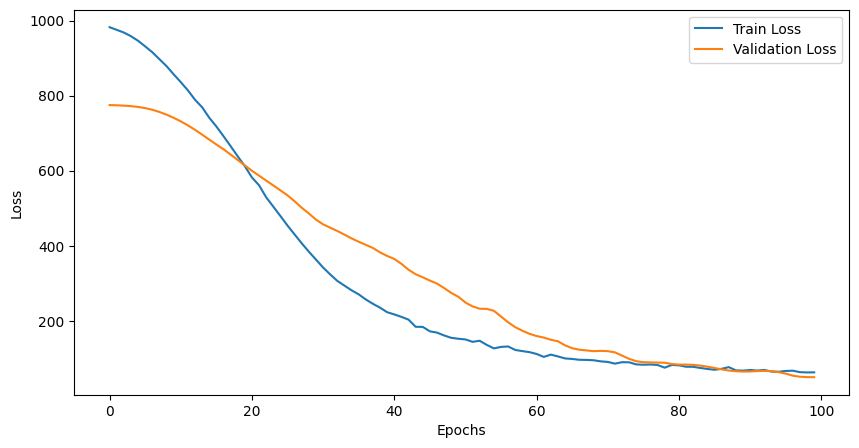

In [61]:
# Initialize model_rGAT, optimizer, and other settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rGAT = RobustGAT(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model_rGAT.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  # Assuming a regression problem

train_losses = []
val_losses = []

# Training Loop
for epoch in range(100):
    model_rGAT.train()
    train_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model_rGAT(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation Loop
    model_rGAT.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model_rGAT(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##### Stats on test data

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

test_data = test_dataset.get(0).to(device)

model_rGAT.eval()
with torch.no_grad():
    predictions = model_rGAT(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions)
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")


MAE: 2.4757726192474365, 
MSE: 49.74394226074219, 
RMSE: 7.052938461303711, 
R-Squared: 0.9224942192010799


In [66]:

# Calculate Haversine distances for all nodes
haversine_distances_rGAT = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions)])

mean_distance = np.mean(haversine_distances_rGAT)
median_distance = np.median(haversine_distances_rGAT)
std_dev = np.std(haversine_distances_rGAT)
min_distance = np.min(haversine_distances_rGAT)
max_distance = np.max(haversine_distances_rGAT)
quartiles = np.percentile(haversine_distances_rGAT, [25, 50, 75])
skewness = stats.skew(haversine_distances_rGAT)
kurtosis = stats.kurtosis(haversine_distances_rGAT)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

Mean: 421.8275418126723, Median: 48.1084854656073, Std Dev: 950.2910874710302
Min: 0.6515818644370696, Max: 10878.588734087043
Quartiles: [  9.94836771  48.10848547 506.20020976]
Skewness: 5.553197168161972, Kurtosis: 42.534006479717156


# CLASSIFIER

## Embeddings

In [ ]:
related_locations = pd.read_csv(f'{DATA_DIR}/country_related_locations.csv')
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from concurrent.futures import ProcessPoolExecutor

# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def simple_get_aggregated_embedding(related_places):
    # Tokenize the related places and truncate/pad them to a fixed length (e.g., 20)
    inputs = tokenizer(related_places, padding=True, truncation=True, return_tensors="pt", max_length=20)

    # Move only the tensor data (not the input_ids) to the same device as the model and convert to half-precision
    inputs = {key: val.to(device).half() if key != 'input_ids' else val.to(device) for key, val in inputs.items()}

    # Convert model to half-precision
    model.half()

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Take the hidden states of the [CLS] tokens for sentence-level embeddings
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Aggregate the embeddings by taking their mean
    aggregated_embedding = np.mean(embeddings, axis=0)

    return aggregated_embedding




def get_aggregated_embedding(related_places):
    max_length = 512  # Set based on model's maximum input size
    stride = 256  # Overlapping window stride

    # Tokenize the text
    tokens = tokenizer.tokenize(related_places)
    # Create overlapping windows
    token_windows = [tokens[i:i + max_length] for i in range(0, len(tokens), stride)]
    embeddings = []

    for window in token_windows:
        # Convert tokens to input IDs and create tensor
        input_ids = tokenizer.convert_tokens_to_ids(window)
        input_tensor = torch.tensor([input_ids]).to(device)  # Move tensor to GPU
        # Generate embeddings
        with torch.no_grad():
            outputs = model(input_tensor)

        # Take the mean of the embeddings
        embeddings.append(outputs.last_hidden_state.mean(dim=1))
    # Aggregate embeddings (mean for simplicity)
    aggregated_embedding = torch.mean(torch.stack(embeddings), dim=0)

    return aggregated_embedding.cpu()  # Move tensor back to CPU if you want to convert it to numpy later



In [ ]:
from concurrent.futures import ThreadPoolExecutor

embeddings=[]

with ThreadPoolExecutor() as executor:
    embeddings = list(executor.map(simple_get_aggregated_embedding, related_locations['related_locations']))

# Add the embeddings to a new column in the DataFrame
related_locations['related_locations_embedings'] = embeddings


## Create KG

### Simple Knowledge Graph with embedding of related places.

In [ ]:
related_locations['related_locations_embedings'] = related_locations['related_locations_embedings'].apply(lambda x: np.random.randint(10**11, 10**12 - 1))
related_locations_dict = {
    row['country']: {
        'related_locations': row['related_locations'],
        'related_locations_embedings': row['related_locations_embedings']
    }
    for index, row in related_locations.iterrows()
}

In [ ]:
def create_knowledge_graph_with_related_places(df):
    G = nx.DiGraph()

    for idx, row in df.iterrows():
        country = row["country"]
        location = row["location"]
        location_latitude = row["location_latitude"]
        location_longitude = row["location_longitude"]
        osm_id = row["osm_id"]
        region = row["region"]
        sub_region = row["sub_region"]
        related_locations_emb = related_locations_dict[country]['related_locations_embedings']


        # Add nodes
        if pd.notna(country) and country!= '':
            G.add_node(country, country=country, type='Country')
        if pd.notna(country) and country!= '':
            G.add_node(related_locations_emb, country=country, type='Related_Locations')
        if pd.notna(location) and location!= '':
            G.add_node(location, location=location, type='Location', osm_id=osm_id)
        if pd.notna(location_latitude) and location_latitude!= '':
            G.add_node(location_latitude, type='Location_Latitude')
        if pd.notna(location_longitude) and location_longitude!= '':
            G.add_node(location_longitude, type='Location_Longitude')
        if pd.notna(region) and region!= '':
            G.add_node(region, region=region, type='Region')
        if pd.notna(sub_region) and sub_region!= '':
            G.add_node(sub_region, sub_region=sub_region, type='Sub_Region')

        # Add edges
        if (pd.notna(country) and country!='') and (pd.notna(location) and location!=''):
            G.add_edge(country, location, relation='has')
        # has_related_locations - country
        if (pd.notna(country) and country!='') and (pd.notna(related_locations_emb) and related_locations_emb!=''):
            G.add_edge(country, related_locations_emb, relation='has_related_locations')

        if (pd.notna(location) and location!='') and (pd.notna(location_latitude) and location_latitude!=''):
            G.add_edge(location, location_latitude, relation='has_latitude')

        if (pd.notna(location) and location!='') and (pd.notna(location_longitude) and location_longitude!=''):
            G.add_edge(location, location_longitude, relation='has_longitude')

        if (pd.notna(country) and country!='') and (pd.notna(region) and region!=''):
            G.add_edge(country, region, relation='is_in')

        if (pd.notna(region) and region!='') and (pd.notna(sub_region) and sub_region!=''):
            G.add_edge(region, sub_region, relation='is_in')

    return G

In [ ]:
# Create the Knowledge Graphs
train_10_15_rp_kg = create_knowledge_graph_with_related_places(train_10_15_df)
val_10_15_rp_kg = create_knowledge_graph_with_related_places(val_10_15_df)
test_10_15_rp_kg = create_knowledge_graph_with_related_places(test_10_15_df)


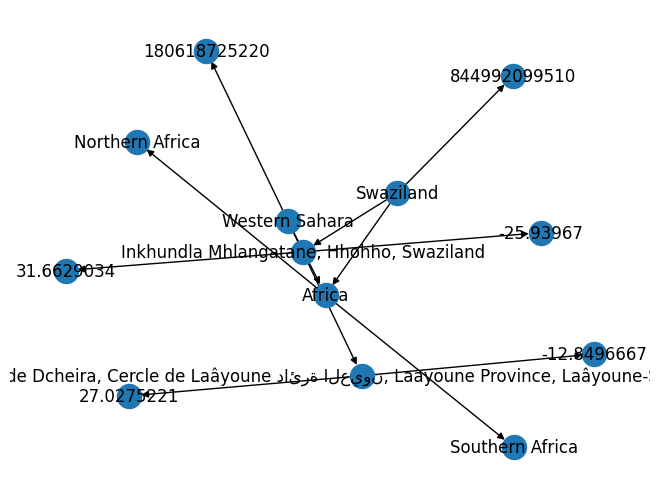

In [201]:
# Testing
G = create_knowledge_graph_with_related_places(train_10_15_df[:2])
nx.draw(G, with_labels=True)
plt.show()

## Generate embeddings

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from queue import Queue
from threading import Thread
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import networkx as nx
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader

In [202]:
train_10_15_rp_emb = generate_kge_with_distilbert(train_10_15_rp_kg)
val_10_15_rp_emb = generate_kge_with_distilbert(val_10_15_rp_kg)
test_10_15_rp_emb = generate_kge_with_distilbert(test_10_15_rp_kg)

RuntimeError: ignored

In [12]:
chunk_size = 5000000  # 500k rows at one go
chunks = []

for chunk in pd.read_csv(f'{DATA_DIR}/planet-latest_geonames.tsv', sep='\t', chunksize=chunk_size):
    # Perform data filtering or transformations here
    chunks.append(chunk[['osm_id','country','alternative_names','display_name']])

# Combine chunks back into single dataframe
planet_geonames = pd.concat(chunks, axis=0)

<ipython-input-12-efd841db5411>:4: DtypeWarning: Columns (10,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f'{DATA_DIR}/planet-latest_geonames.tsv', sep='\t', chunksize=chunk_size):
<ipython-input-12-efd841db5411>:4: DtypeWarning: Columns (10,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f'{DATA_DIR}/planet-latest_geonames.tsv', sep='\t', chunksize=chunk_size):
<ipython-input-12-efd841db5411>:4: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f'{DATA_DIR}/planet-latest_geonames.tsv', sep='\t', chunksize=chunk_size):
<ipython-input-12-efd841db5411>:4: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f'{DATA_DIR}/planet-latest_geonames.tsv', sep='\t', chunksize=chunk_size):


In [4]:
country_osm_id_locations=pd.read_pickle(f'{DATA_DIR}/country_osm_id_locations.pkl')

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
!pip install -q swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [16]:
country_osm_id_locations= planet_geonames.copy()

In [17]:
import pandas as pd
import re
import swifter  # for parallel processing


def preprocess_text(text):
    text = str(text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.split()  # Tokenize
    text = [word for word in text if word.lower() not in stop_words] # Remove stopwords
    return ' '.join(text)


# Using Swifter to parallelize the apply function
country_osm_id_locations[['country', 'display_name','alternative_names']] = country_osm_id_locations[['country', 'display_name','alternative_names']].swifter.applymap(preprocess_text)


Pandas Apply:   0%|          | 0/71630883 [00:00<?, ?it/s]

In [25]:
country_osm_id_locations.to_pickle(f'{DATA_DIR}/country_osm_id_locations.pkl')

In [3]:
country_osm_id_locations = pd.read_pickle(f'{DATA_DIR}/country_osm_id_locations.pkl')

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
import pandas as pd

# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def embed_texts(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=20)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to device

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings

# Create DataLoader
batch_size = 32 # You can change this
text_data = country_osm_id_locations['alternative_names'].tolist()
text_loader = DataLoader(text_data, batch_size=batch_size, num_workers=16, shuffle=False)

# Embedding and storing in list
all_embeddings = []
for texts in tqdm(text_loader):
    embeddings = embed_texts(texts)
    all_embeddings.extend(embeddings)

# Add the embeddings to the DataFrame
country_osm_id_locations['location_embedding'] = all_embeddings


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 82%|████████▏ | 612356/746156 [1:52:57<105:03:15,  2.83s/it]

In [14]:
gc.collect()

2579

In [ ]:
gc.collect()